# Import

In [1]:
# 데이터 처리
import pandas as pd
import numpy as np

# 시각화 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.stats import chi2_contingency


# 한글 깨짐 방지 (윈도우)
import platform
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')

# 그래프에서 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 경고 메시지 숨기기 (필요시)
import warnings
warnings.filterwarnings('ignore')

# File

In [2]:
# knhanes 불러오기
df = pd.read_csv('./data/knhanes.csv')

# EDA(결측치 및 데이터 전처리 작업)

In [3]:
# copy 후 작업
df_diabetes = df.copy()

# 결측 비율 계산
missing_ratio = df_diabetes.isnull().mean()
# print(missing_ratio['HE_mPLS'])

# 결측률 30% 이상인 컬럼 제거
df_diabetes = df_diabetes.drop(columns=missing_ratio[missing_ratio >= 0.3].index)


In [4]:
print(missing_ratio['HE_Uglu'])
print(missing_ratio['HE_mPLS'])

0.09914850627796219
0.8960889017174195


### 1. 새로운 라벨 컬럼 생성 및 상관계수 상위 30개 변수 히트맵으로 확인

#### 새로운 라벨 컬럼 생성

In [5]:
# # 새로운 라벨 컬럼
# df_diabetes['diabetes_label'] = ((df_diabetes['DE1_dg'] == 1) & (df_diabetes['HE_DM_HbA1c'] == 3)).astype(int)

# 혈액검사상 당뇨고 의사 진단도 당뇨
cond_both = (df_diabetes['DE1_dg'] == 1) & (df_diabetes['HE_DM_HbA1c'] == 3)

# 혈액검사상 당뇨지만, 의사 진단은 아님
cond_he_only = (df_diabetes['HE_DM_HbA1c'] == 3) & (df_diabetes['DE1_dg'] != 1)

# 새로운 조건 통합 라벨
df_diabetes['diabetes_label'] = (cond_both | cond_he_only).astype(int)

# 확인
print("라벨 1로 지정된 데이터 수:", df_diabetes['diabetes_label'].sum())

라벨 1로 지정된 데이터 수: 860


#### 수축기, 이완기 3회측정 평균값 컬럼 생성

In [6]:
# 수축기, 이완기 3회측정 평균값
df_diabetes['SBP_mean'] = df_diabetes[['HE_sbp1', 'HE_sbp2', 'HE_sbp3']].mean(axis=1)
df_diabetes['DBP_mean'] = df_diabetes[['HE_dbp1', 'HE_dbp2', 'HE_dbp3']].mean(axis=1)


#### 상관계수 상위 30개 변수 히트맵으로 확인

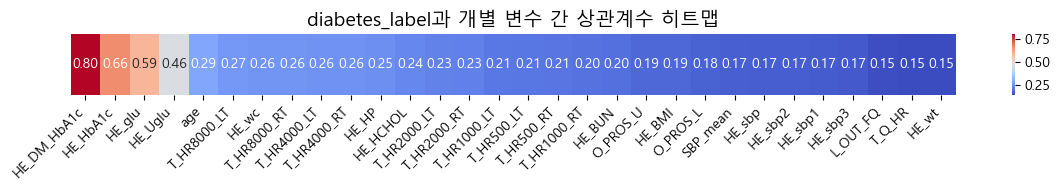

In [7]:
# 상관계수 계산
corr_series = df_diabetes.corr(numeric_only=True)['diabetes_label'].drop('diabetes_label').sort_values(ascending=False)

# 상위 20개 변수만 추출
top_20_corr = corr_series.head(30)

# 히트맵용 데이터프레임 만들기 (1행짜리)
heatmap_df = top_20_corr.to_frame().T

# 히트맵 시각화
plt.figure(figsize=(12, 2))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('diabetes_label과 개별 변수 간 상관계수 히트맵', fontsize=14)
plt.yticks([])  # y축 생략 (1줄짜리라 의미 없음)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 이 data에선 나이 및 청력에 고주파 충주파 저주파가 있는 사람들한테 diabetes_label과 관련이 많음 
# (즉, 당뇨 → 귀로 가는 혈류 감소 + 신경 손상 → 청력 저하 가능성 ↑) 미국 NIH 연구에 따르면, 당뇨병 환자는 비당뇨인 사람보다 청력 손실 확률이 약 2배 높음


### 2. diabetes_label의 주요 의학 변수 간 상관계수 히트맵

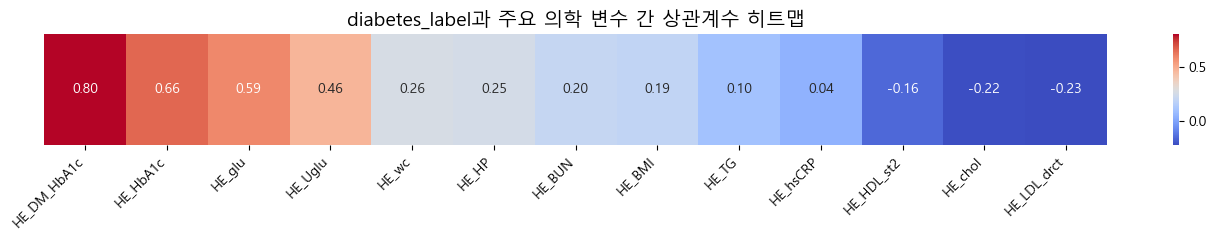

In [30]:
# 주요 변수 목록 (정제된 코드 형식)
medical_vars = [
    'HE_DM_HbA1c', 'HE_glu', 'HE_Uglu', 'HE_HbA1c', 'HE_hsCRP',
    'HE_chol', 'HE_HDL_st2', 'HE_BUN', 'HE_TG', 'HE_LDL_drct',
    'HE_wc', 'HE_BMI', 'HE_HP',
    'SBP_mean','DBP_mean'
]

# 컬럼 필터링
valid_vars = [col for col in medical_vars if col in df.columns]

# 상관계수 계산
filtered_corr = df_diabetes[valid_vars + ['diabetes_label']].corr(numeric_only=True)['diabetes_label'].drop('diabetes_label').sort_values(ascending=False)

# 1행짜리 데이터프레임 변환 (히트맵용)
heatmap_df_key = filtered_corr.to_frame().T

# 히트맵 시각화
plt.figure(figsize=(14, 2.5))
sns.heatmap(heatmap_df_key, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('diabetes_label과 주요 의학 변수 간 상관계수 히트맵', fontsize=14)
plt.yticks([])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### 3. both_diabetes와 he_only의 비교 (he_only도 당뇨병 진단자로 포함시킬지 확인)

In [29]:

# 1. 두 컬럼 모두 당뇨인 그룹
both_diabetes = df_diabetes[(df_diabetes['DE1_dg'] == 1) & (df_diabetes['HE_DM_HbA1c'] == 3)]

# 2. HbA1c는 당뇨 상태지만 의사 진단은 당뇨 아님
he_only = df_diabetes[(df_diabetes['HE_DM_HbA1c'] == 3) & (df_diabetes['DE1_dg'] != 1)]

# 비교할 주요 의학 변수 목록
medical_vars = [
    'HE_DM_HbA1c', 'HE_glu', 'HE_Uglu', 'HE_HbA1c', 'HE_hsCRP',
    'HE_chol', 'HE_HDL_st2', 'HE_BUN', 'HE_TG', 'HE_LDL_drct',
    'HE_wc', 'HE_BMI','HE_HP',
    'SBP_mean','DBP_mean'
]

# 변수별 평균 비교
comparison_stats = []
for var in medical_vars:
    if var in df_diabetes.columns:
        mean_both = both_diabetes[var].mean()
        mean_he_only = he_only[var].mean()
        comparison_stats.append({
            '변수명': var,
            '둘다 당뇨 그룹 평균': round(mean_both, 2),
            '진단X & HbA1c만 당뇨 평균': round(mean_he_only, 2)
        })

comparison_df = pd.DataFrame(comparison_stats)

comparison_df


,변수명,둘다 당뇨 그룹 평균,진단X & HbA1c만 당뇨 평균
0,HE_DM_HbA1c,3.00,3.00
1,HE_glu,131.91,141.82
2,HE_Uglu,1.43,0.77
3,HE_HbA1c,6.89,6.91
4,HE_hsCRP,1.77,2.73
5,HE_chol,151.10,192.59
6,HE_HDL_st2,51.03,50.06
7,HE_BUN,16.70,15.39
8,HE_TG,133.52,187.10
9,HE_LDL_drct,82.22,116.80


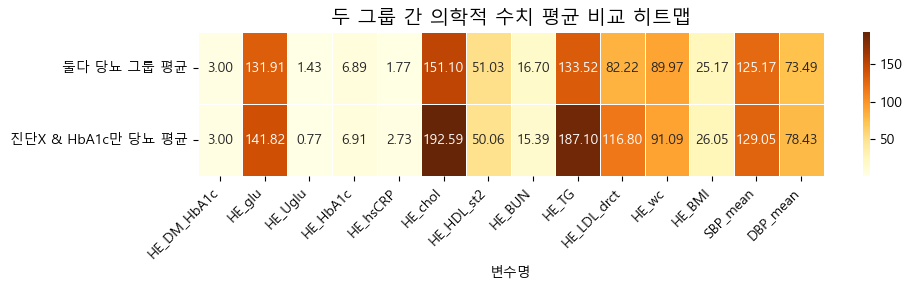

In [10]:
# 비교할 변수명만 추출
selected_vars = comparison_df['변수명'].tolist()

# 그룹별 평균값 데이터프레임을 변환 (히트맵용: 변수명 기준 행, 그룹 기준 열)
heatmap_data = comparison_df.set_index('변수명').T

# 히트맵 시각화
plt.figure(figsize=(10, 3))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='YlOrBr', linewidths=0.5, cbar=True)
plt.title('두 그룹 간 의학적 수치 평균 비교 히트맵', fontsize=14)
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# EDA(당뇨 vs 비당뇨 그룹간 수치 분포)

### HE_glu : 공복혈당

공복혈당 (HE_glu) 기본 통계량 (당뇨 vs 비당뇨):

                 count        mean        std   min    25%    50%    75%  \
diabetes_label                                                             
0               5324.0   94.904583  12.302969  60.0   88.0   93.0  100.0   
1                860.0  134.141860  39.956010  61.0  111.0  127.0  143.0   

                  max  
diabetes_label         
0               356.0  
1               398.0   



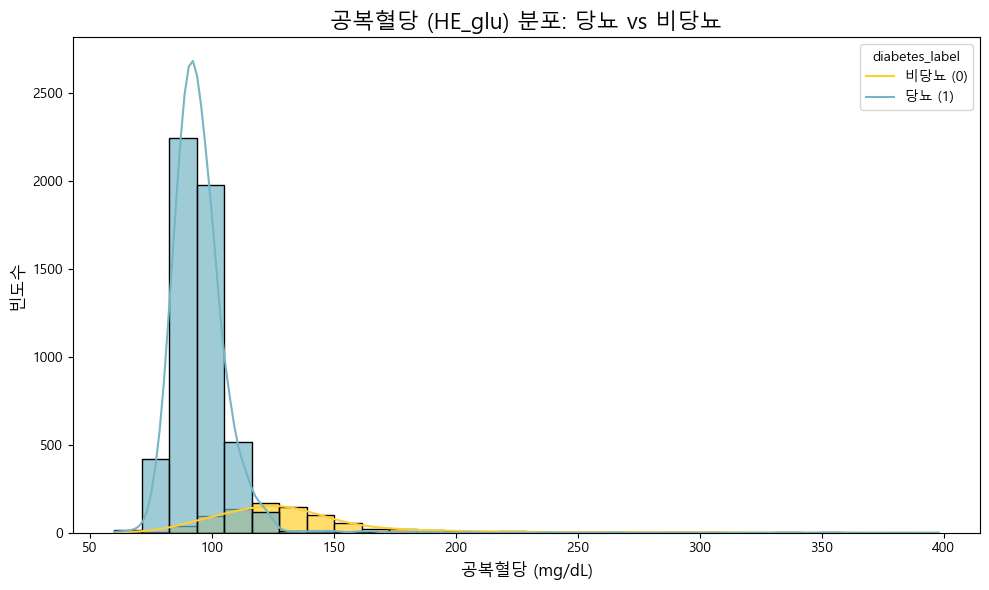

In [11]:
# 결측치 제거한 전체 데이터에서 비교
glu_data = df_diabetes[['diabetes_label', 'HE_glu']].dropna()

# 기본 통계량
print("공복혈당 (HE_glu) 기본 통계량 (당뇨 vs 비당뇨):\n")
print(glu_data.groupby('diabetes_label')['HE_glu'].describe(), "\n")

# 시각화
plt.figure(figsize=(10, 6))
sns.histplot(data=glu_data, x='HE_glu', hue='diabetes_label', bins=30, kde=True,
             palette={0: "#76b5c5", 1: "#ffcf32"}, edgecolor="black", alpha=0.7)

plt.title('공복혈당 (HE_glu) 분포: 당뇨 vs 비당뇨', fontsize=16)
plt.xlabel('공복혈당 (mg/dL)', fontsize=12)
plt.ylabel('빈도수', fontsize=12)
plt.legend(title='diabetes_label', labels=['비당뇨 (0)', '당뇨 (1)'])
plt.tight_layout()
plt.show()

### HE_Uglu : 요당

요당 (HE_Uglu) 기본 통계량 (당뇨 vs 비당뇨):

                 count      mean       std  min  25%  50%  75%  max
diabetes_label                                                     
0               5391.0  0.034131  0.360303  0.0  0.0  0.0  0.0  5.0
1                851.0  1.279671  2.021484  0.0  0.0  0.0  3.0  5.0 



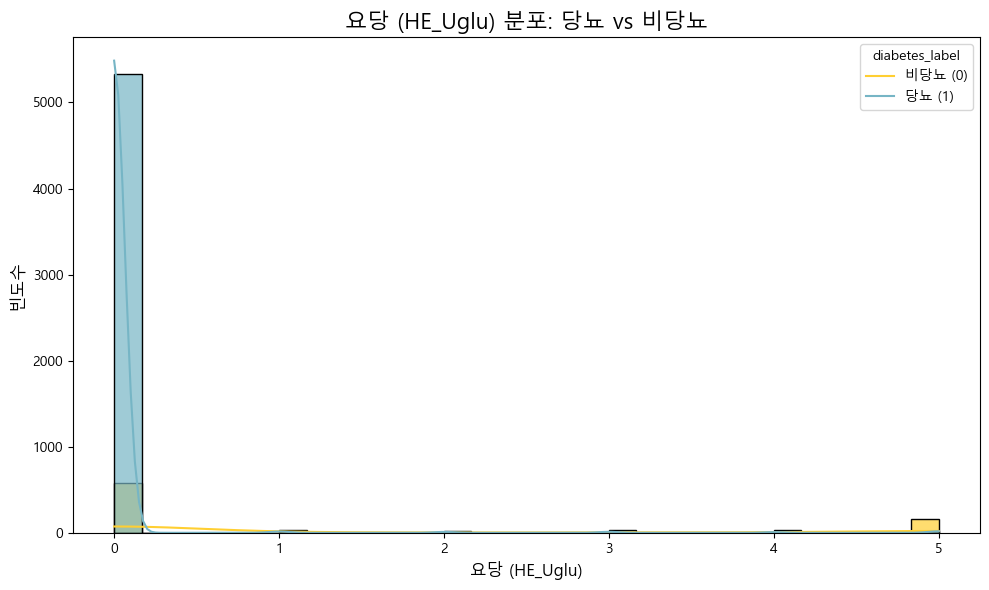

In [12]:
# 결측치 제거한 전체 데이터에서 비교
uglu_data = df_diabetes[['diabetes_label', 'HE_Uglu']].dropna()

# 기본 통계량
print("요당 (HE_Uglu) 기본 통계량 (당뇨 vs 비당뇨):\n")
print(uglu_data.groupby('diabetes_label')['HE_Uglu'].describe(), "\n")

# 시각화
plt.figure(figsize=(10, 6))
sns.histplot(data=uglu_data, x='HE_Uglu', hue='diabetes_label', bins=30, kde=True,
             palette={0: "#76b5c5", 1: "#ffcf32"}, edgecolor="black", alpha=0.7)
plt.title('요당 (HE_Uglu) 분포: 당뇨 vs 비당뇨', fontsize=16)
plt.xlabel('요당 (HE_Uglu)', fontsize=12)
plt.ylabel('빈도수', fontsize=12)
plt.legend(title='diabetes_label', labels=['비당뇨 (0)', '당뇨 (1)'])
plt.tight_layout()
plt.show()

### HE_HbA1c : 당화혈색소

당화혈색소 (HE_HbA1c) 기본 통계량 (당뇨 vs 비당뇨):

                 count      mean       std  min  25%  50%  75%   max
diabetes_label                                                      
0               5305.0  5.402036  0.412854  4.1  5.2  5.4  5.6  17.6
1                860.0  6.894186  1.218069  4.9  6.2  6.6  7.2  16.4 



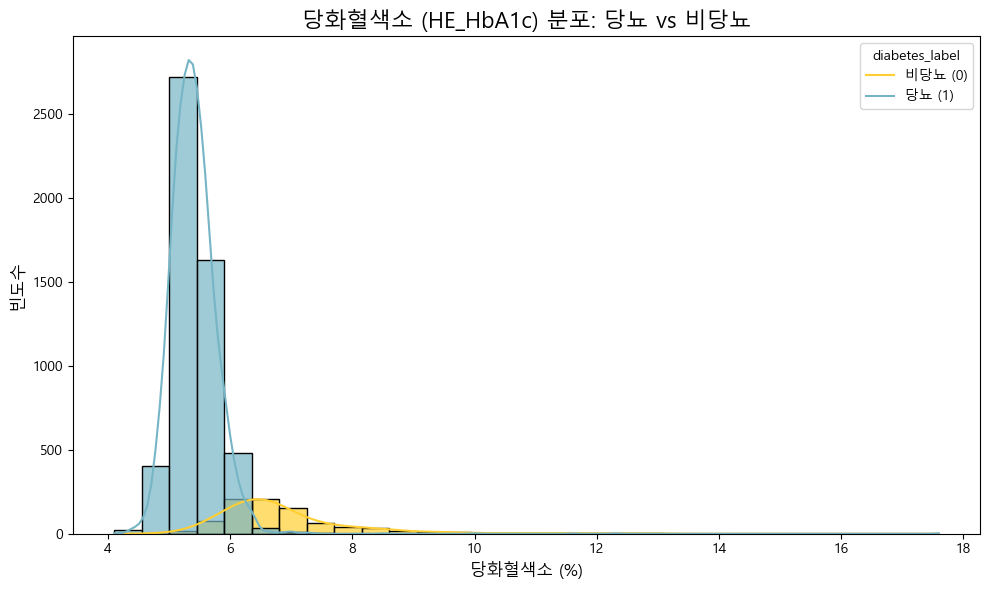

In [13]:
# 결측치 제거한 전체 데이터에서 비교
hba1c_data = df_diabetes[['diabetes_label', 'HE_HbA1c']].dropna()

# 기본 통계량
print("당화혈색소 (HE_HbA1c) 기본 통계량 (당뇨 vs 비당뇨):\n")
print(hba1c_data.groupby('diabetes_label')['HE_HbA1c'].describe(), "\n")

plt.figure(figsize=(10, 6))
sns.histplot(data=hba1c_data, x='HE_HbA1c', hue='diabetes_label', bins=30, kde=True,
             palette={0: "#76b5c5", 1: "#ffcf32"}, edgecolor="black", alpha=0.7)
plt.title('당화혈색소 (HE_HbA1c) 분포: 당뇨 vs 비당뇨', fontsize=16)
plt.xlabel('당화혈색소 (%)', fontsize=12)
plt.ylabel('빈도수', fontsize=12)
plt.legend(title='diabetes_label', labels=['비당뇨 (0)', '당뇨 (1)'])
plt.tight_layout()
plt.show()

### HE_hsCRP : 고감도 CRP

고감도 CRP (HE_hsCRP) 기본 통계량 (당뇨 vs 비당뇨):

                 count      mean       std  min  25%  50%  75%    max
diabetes_label                                                       
0               4415.0  1.461291  4.276914  0.2  0.3  0.6  1.2  120.1
1                761.0  1.997240  7.638080  0.2  0.4  0.7  1.3  166.0 



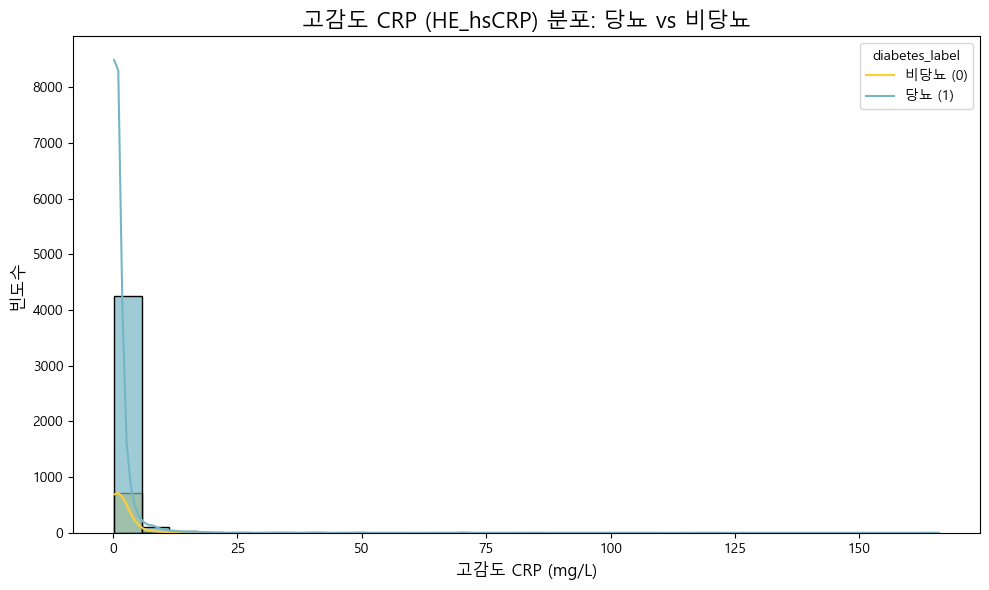

In [14]:
# 결측치 제거한 전체 데이터에서 비교
crp_data = df_diabetes[['diabetes_label', 'HE_hsCRP']].dropna()

# 기본 통계량
print("고감도 CRP (HE_hsCRP) 기본 통계량 (당뇨 vs 비당뇨):\n")
print(crp_data.groupby('diabetes_label')['HE_hsCRP'].describe(), "\n")

plt.figure(figsize=(10, 6))
sns.histplot(data=crp_data, x='HE_hsCRP', hue='diabetes_label', bins=30, kde=True,
             palette={0: "#76b5c5", 1: "#ffcf32"}, edgecolor="black", alpha=0.7)
plt.title('고감도 CRP (HE_hsCRP) 분포: 당뇨 vs 비당뇨', fontsize=16)
plt.xlabel('고감도 CRP (mg/L)', fontsize=12)
plt.ylabel('빈도수', fontsize=12)
plt.legend(title='diabetes_label', labels=['비당뇨 (0)', '당뇨 (1)'])
plt.tight_layout()
plt.show()

### HE_chol : 총콜레스테롤

총콜레스테롤 (HE_chol)기본 통계량 (당뇨 vs 비당뇨):

                 count        mean        std   min    25%    50%    75%  \
diabetes_label                                                             
0               5324.0  186.034936  38.104619  70.0  159.0  184.0  210.0   
1                860.0  160.455814  43.576319  76.0  130.0  153.5  183.0   

                  max  
diabetes_label         
0               456.0  
1               421.0   



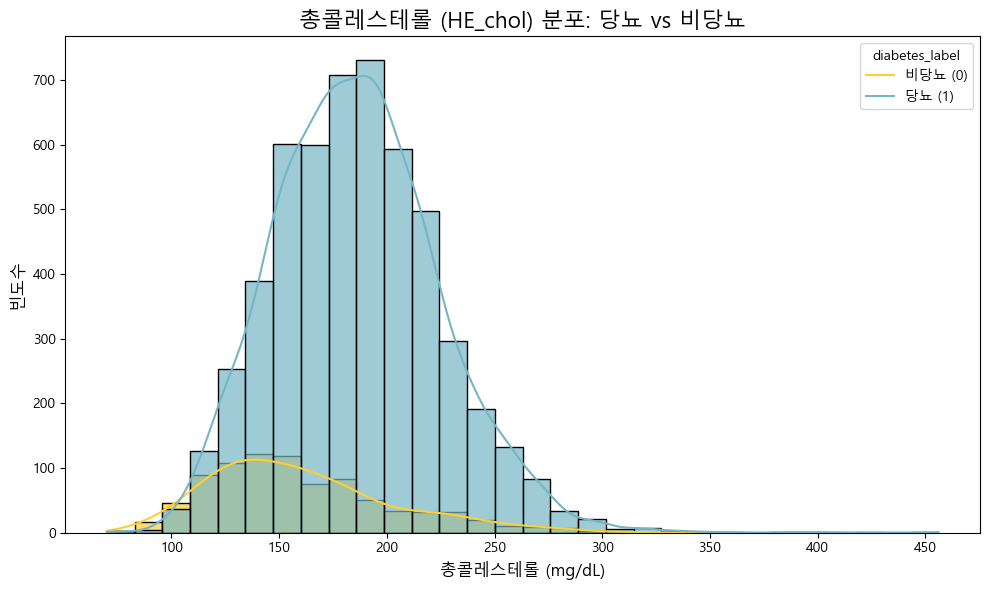

In [15]:
# 결측치 제거한 전체 데이터에서 비교
chol_data = df_diabetes[['diabetes_label', 'HE_chol']].dropna()

# 기본 통계량
print("총콜레스테롤 (HE_chol)기본 통계량 (당뇨 vs 비당뇨):\n")
print(chol_data.groupby('diabetes_label')['HE_chol'].describe(), "\n")

# 시각화
plt.figure(figsize=(10, 6))
sns.histplot(data=chol_data, x='HE_chol', hue='diabetes_label', bins=30, kde=True,
             palette={0: "#76b5c5", 1: "#ffcf32"}, edgecolor="black", alpha=0.7)
plt.title('총콜레스테롤 (HE_chol) 분포: 당뇨 vs 비당뇨', fontsize=16)
plt.xlabel('총콜레스테롤 (mg/dL)', fontsize=12)
plt.ylabel('빈도수', fontsize=12)
plt.legend(title='diabetes_label', labels=['비당뇨 (0)', '당뇨 (1)'])
plt.tight_layout()
plt.show()

### HE_HDL_st2 : HDL 콜레스테롤

'HDL 콜레스테롤 (HE_HDL_st2) 기본 통계량 (당뇨 vs 비당뇨):

                 count       mean        std   min   25%   50%   75%    max
diabetes_label                                                             
0               5324.0  57.995304  15.303338   6.0  47.0  56.0  67.0  135.0
1                860.0  50.806977  14.054607  22.0  41.0  49.0  59.0  116.0 



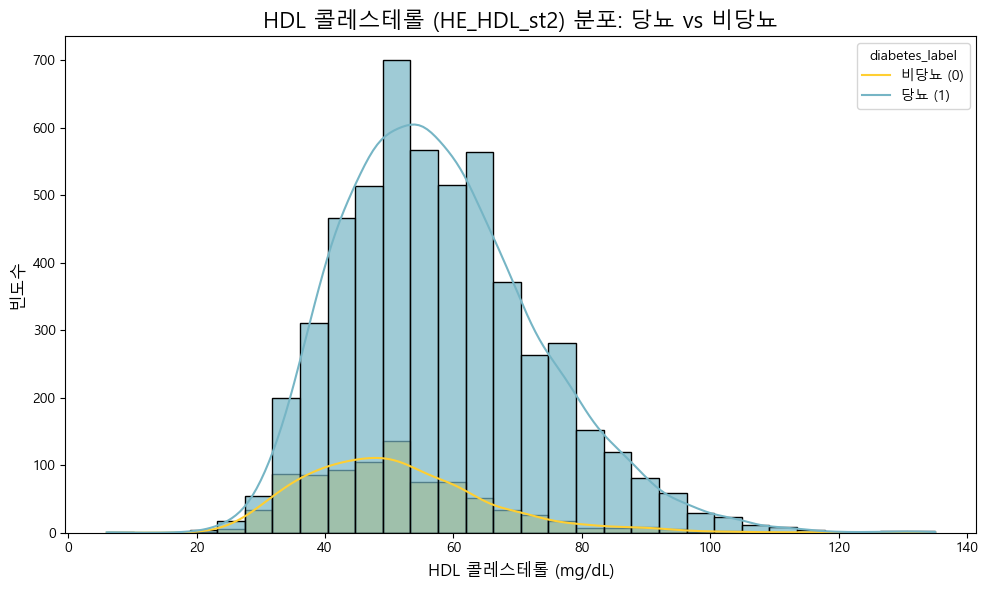

In [16]:
# 결측치 제거한 전체 데이터에서 비교
hdl_data = df_diabetes[['diabetes_label', 'HE_HDL_st2']].dropna()

# 기본 통계량
print("'HDL 콜레스테롤 (HE_HDL_st2) 기본 통계량 (당뇨 vs 비당뇨):\n")
print(hdl_data.groupby('diabetes_label')['HE_HDL_st2'].describe(), "\n")

# 시각화
plt.figure(figsize=(10, 6))
sns.histplot(data=hdl_data, x='HE_HDL_st2', hue='diabetes_label', bins=30, kde=True,
             palette={0: "#76b5c5", 1: "#ffcf32"}, edgecolor="black", alpha=0.7)
plt.title('HDL 콜레스테롤 (HE_HDL_st2) 분포: 당뇨 vs 비당뇨', fontsize=16)
plt.xlabel('HDL 콜레스테롤 (mg/dL)', fontsize=12)
plt.ylabel('빈도수', fontsize=12)
plt.legend(title='diabetes_label', labels=['비당뇨 (0)', '당뇨 (1)'])
plt.tight_layout()
plt.show()

### HE_BUN : 혈중 요소질소

혈중 요소질소 (HE_BUN) 기본 통계량 (당뇨 vs 비당뇨):

                 count       mean       std  min   25%   50%   75%   max
diabetes_label                                                          
0               5324.0  13.794328  4.245690  3.0  11.0  13.0  16.0  90.0
1                860.0  16.406977  5.373322  7.0  13.0  16.0  19.0  54.0 



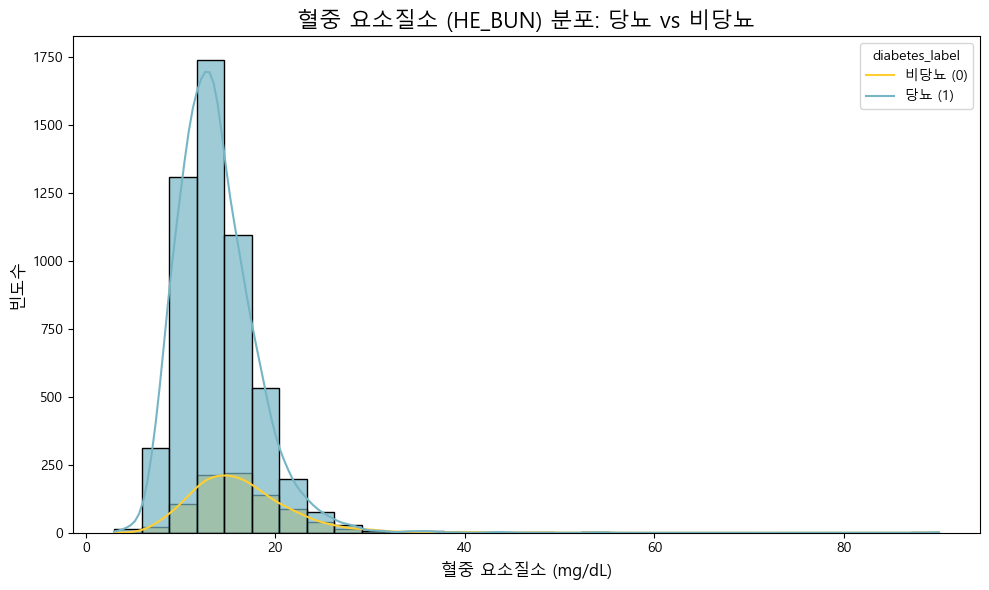

In [17]:
# 결측치 제거한 전체 데이터에서 비교
bun_data = df_diabetes[['diabetes_label', 'HE_BUN']].dropna()

# 기본 통계량 출력
print("혈중 요소질소 (HE_BUN) 기본 통계량 (당뇨 vs 비당뇨):\n")
print(bun_data.groupby('diabetes_label')['HE_BUN'].describe(), "\n")

# 시각화
plt.figure(figsize=(10, 6))
sns.histplot(data=bun_data, x='HE_BUN', hue='diabetes_label', bins=30, kde=True,
             palette={0: "#76b5c5", 1: "#ffcf32"}, edgecolor="black", alpha=0.7)
plt.title('혈중 요소질소 (HE_BUN) 분포: 당뇨 vs 비당뇨', fontsize=16)
plt.xlabel('혈중 요소질소 (mg/dL)', fontsize=12)
plt.ylabel('빈도수', fontsize=12)
plt.legend(title='diabetes_label', labels=['비당뇨 (0)', '당뇨 (1)'])
plt.tight_layout()
plt.show()

### HE_TG : 중성지방 

중성지방 (HE_TG) 기본 통계량 (당뇨 vs 비당뇨):

                 count        mean         std   min   25%    50%    75%  \
diabetes_label                                                             
0               5324.0  118.727648   93.183727  24.0  71.0   98.0  140.0   
1                860.0  145.609302  109.878421  29.0  87.0  121.0  170.0   

                   max  
diabetes_label          
0               3367.0  
1               1489.0   



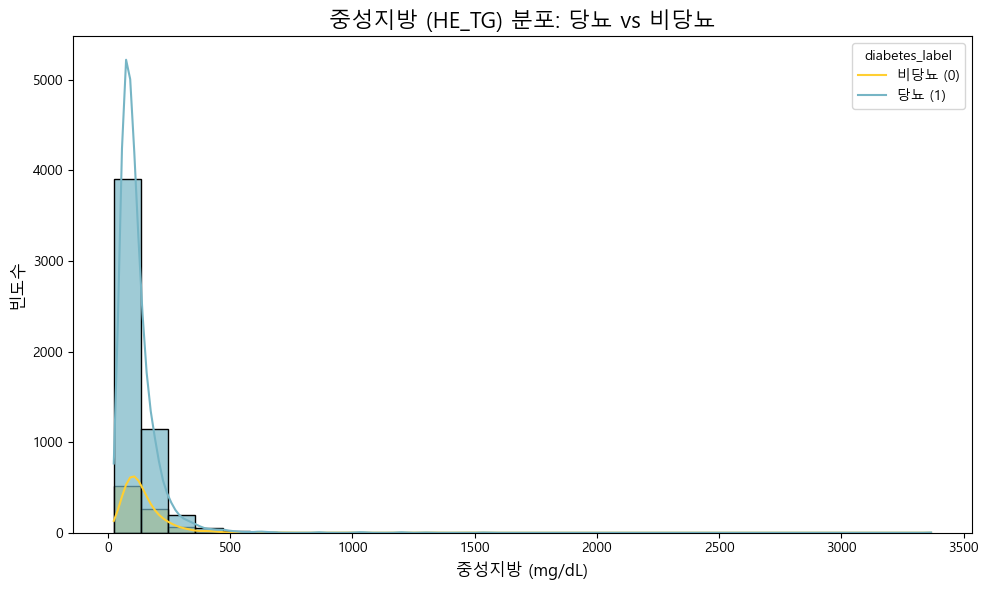

In [18]:
# 결측치 제거한 데이터
tg_data = df_diabetes[['diabetes_label', 'HE_TG']].dropna()

# 기본 통계량 출력
print("중성지방 (HE_TG) 기본 통계량 (당뇨 vs 비당뇨):\n")
print(tg_data.groupby('diabetes_label')['HE_TG'].describe(), "\n")

# 시각화
plt.figure(figsize=(10, 6))
sns.histplot(data=tg_data, x='HE_TG', hue='diabetes_label', bins=30, kde=True,
             palette={0: "#76b5c5", 1: "#ffcf32"}, edgecolor="black", alpha=0.7)
plt.title('중성지방 (HE_TG) 분포: 당뇨 vs 비당뇨', fontsize=16)
plt.xlabel('중성지방 (mg/dL)', fontsize=12)
plt.ylabel('빈도수', fontsize=12)
plt.legend(title='diabetes_label', labels=['비당뇨 (0)', '당뇨 (1)'])
plt.tight_layout()
plt.show()

### HE_LDL_drct : LDL 콜레스테롤

LDL 콜레스테롤 (HE_LDL_drct) 기본 통계량 (당뇨 vs 비당뇨):

                 count        mean        std   min   25%    50%     75%  \
diabetes_label                                                             
0               5324.0  113.657400  34.631110  10.0  89.0  112.0  136.00   
1                860.0   90.022093  37.892971  27.0  64.0   81.0  109.25   

                  max  
diabetes_label         
0               337.0  
1               323.0   



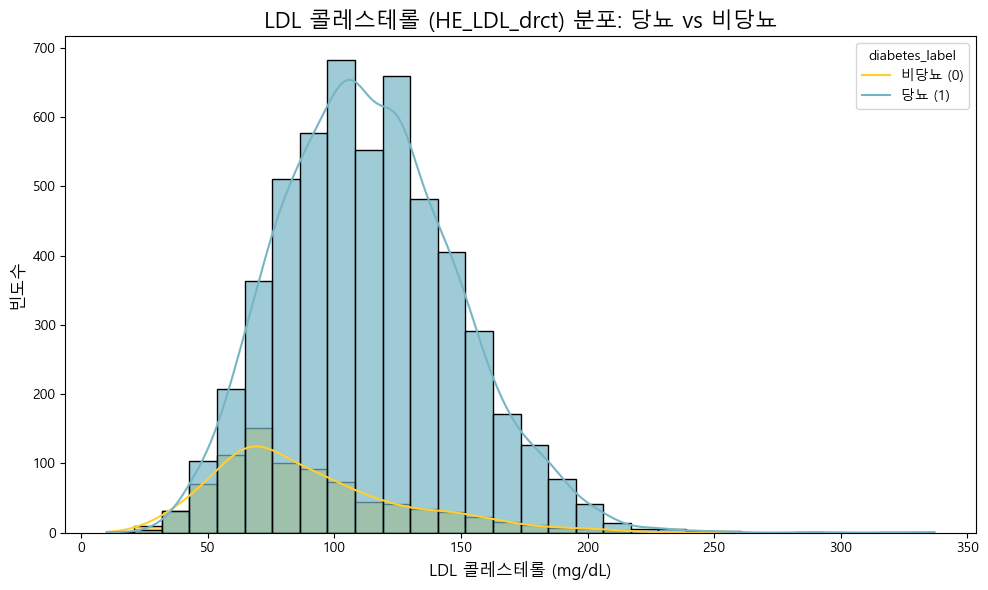

In [19]:
# 결측치 제거한 데이터
ldl_data = df_diabetes[['diabetes_label', 'HE_LDL_drct']].dropna()

# 기본 통계량 출력
print("LDL 콜레스테롤 (HE_LDL_drct) 기본 통계량 (당뇨 vs 비당뇨):\n")
print(ldl_data.groupby('diabetes_label')['HE_LDL_drct'].describe(), "\n")

# 히스토그램 시각화
plt.figure(figsize=(10, 6))
sns.histplot(data=ldl_data, x='HE_LDL_drct', hue='diabetes_label', bins=30, kde=True,
             palette={0: "#76b5c5", 1: "#ffcf32"}, edgecolor="black", alpha=0.7)

plt.title('LDL 콜레스테롤 (HE_LDL_drct) 분포: 당뇨 vs 비당뇨', fontsize=16)
plt.xlabel('LDL 콜레스테롤 (mg/dL)', fontsize=12)
plt.ylabel('빈도수', fontsize=12)
plt.legend(title='diabetes_label', labels=['비당뇨 (0)', '당뇨 (1)'])
plt.tight_layout()
plt.show()

### 'HE_wc' 허리둘레

허리둘레 (HE_wc) 기본 통계량 (당뇨 vs 비당뇨):

                 count       mean        std   min   25%   50%   75%    max
diabetes_label                                                             
0               5675.0  80.700934  12.122863  43.4  72.5  81.1  89.1  132.0
1                835.0  90.226347   9.960040  65.6  83.7  89.7  95.8  125.7 



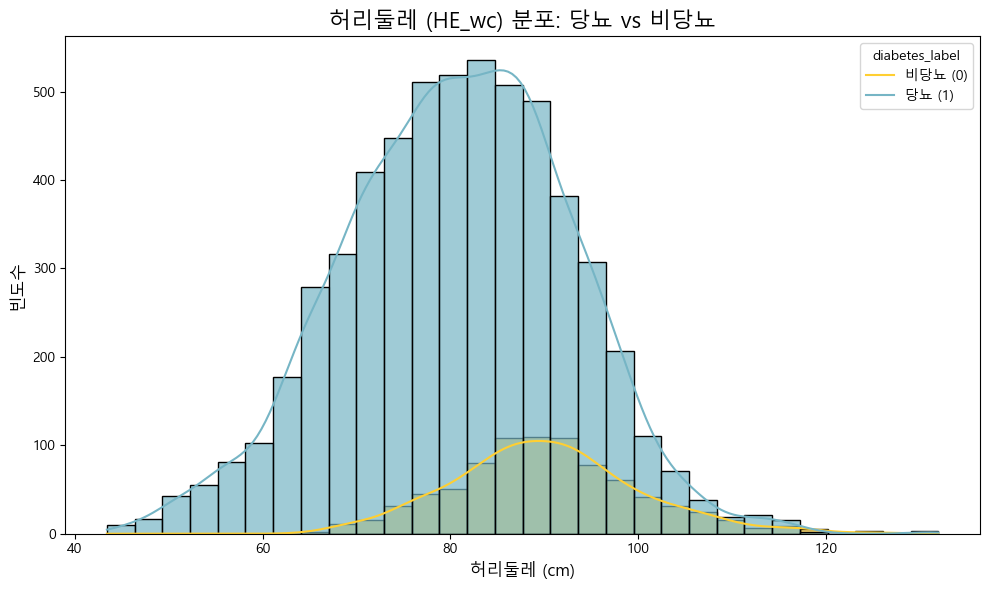

In [20]:

# 결측치 제거한 데이터
wc_data = df_diabetes[['diabetes_label', 'HE_wc']].dropna()

# 기본 통계량 출력
print("허리둘레 (HE_wc) 기본 통계량 (당뇨 vs 비당뇨):\n")
print(wc_data.groupby('diabetes_label')['HE_wc'].describe(), "\n")

# 히스토그램 시각화
plt.figure(figsize=(10, 6))
sns.histplot(data=wc_data, x='HE_wc', hue='diabetes_label', bins=30, kde=True,
             palette={0: "#76b5c5", 1: "#ffcf32"}, edgecolor="black", alpha=0.7)
plt.title('허리둘레 (HE_wc) 분포: 당뇨 vs 비당뇨', fontsize=16)
plt.xlabel('허리둘레 (cm)', fontsize=12)
plt.ylabel('빈도수', fontsize=12)
plt.legend(title='diabetes_label', labels=['비당뇨 (0)', '당뇨 (1)'])
plt.tight_layout()
plt.show()

### 'HE_BMI' 체질량지수

'체질량지수 (HE_BMI) 기본 통계량 (당뇨 vs 비당뇨):

                 count       mean       std        min        25%        50%  \
diabetes_label                                                                 
0               5986.0  22.966189  4.124664  11.894753  20.214087  22.886695   
1                827.0  25.373146  3.872419  16.074850  22.927221  24.927359   

                      75%        max  
diabetes_label                        
0               25.499377  42.855921  
1               27.283874  44.339130   



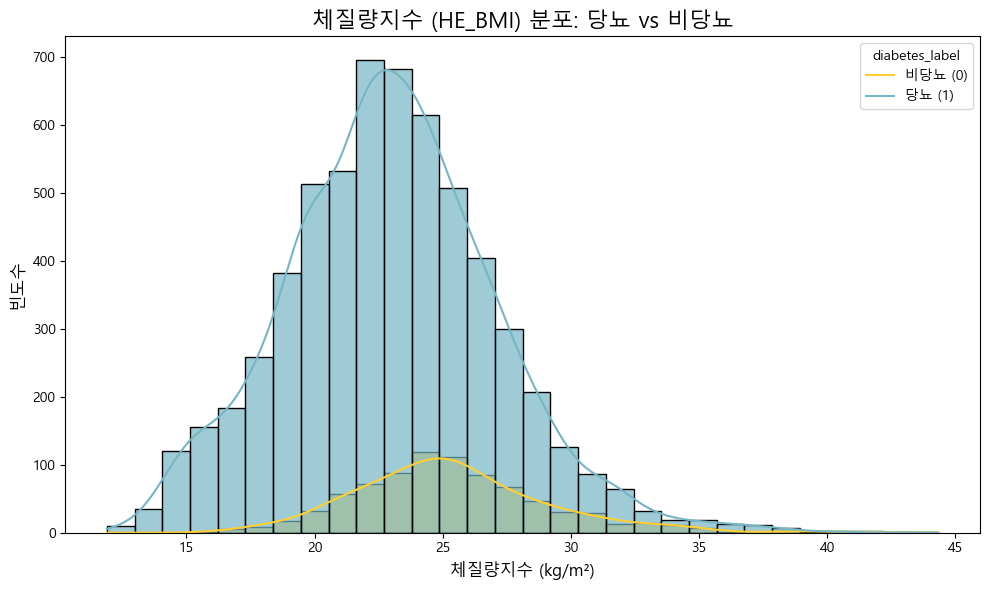

In [21]:
# 결측치 제거한 데이터
bmi_data = df_diabetes[['diabetes_label', 'HE_BMI']].dropna()

# 기본 통계량 출력
print("'체질량지수 (HE_BMI) 기본 통계량 (당뇨 vs 비당뇨):\n")
print(bmi_data.groupby('diabetes_label')['HE_BMI'].describe(), "\n")

# 히스토그램 시각화

plt.figure(figsize=(10, 6))
sns.histplot(data=bmi_data, x='HE_BMI', hue='diabetes_label', bins=30, kde=True,
             palette={0: "#76b5c5", 1: "#ffcf32"}, edgecolor="black", alpha=0.7)
plt.title('체질량지수 (HE_BMI) 분포: 당뇨 vs 비당뇨', fontsize=16)
plt.xlabel('체질량지수 (kg/m²)', fontsize=12)
plt.ylabel('빈도수', fontsize=12)
plt.legend(title='diabetes_label', labels=['비당뇨 (0)', '당뇨 (1)'])
plt.tight_layout()
plt.show()

### HE_sbp : 수축기 & HE_dbp : 이완기

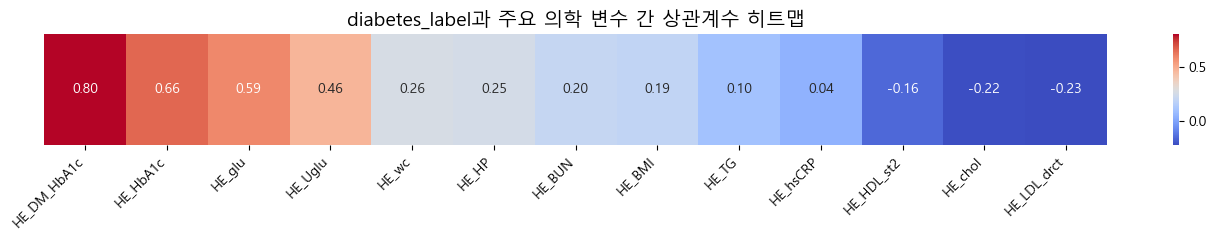

In [ ]:
# 주요 변수 목록 (정제된 코드 형식)
medical_vars = [
    'HE_DM_HbA1c', 'HE_glu', 'HE_Uglu', 'HE_HbA1c', 'HE_hsCRP',
    'HE_chol', 'HE_HDL_st2', 'HE_BUN', 'HE_TG', 'HE_LDL_drct',
    'HE_wc', 'HE_BMI', 'HE_HP',
    'SBP_mean','DBP_mean'
]

# 컬럼 필터링
valid_vars = [col for col in medical_vars if col in df.columns]

# 상관계수 계산
filtered_corr = df_diabetes[valid_vars + ['diabetes_label']].corr(numeric_only=True)['diabetes_label'].drop('diabetes_label').sort_values(ascending=False)

# 1행짜리 데이터프레임 변환 (히트맵용)
heatmap_df_key = filtered_corr.to_frame().T

# 히트맵 시각화
plt.figure(figsize=(14, 2.5))
sns.heatmap(heatmap_df_key, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('diabetes_label과 주요 의학 변수 간 상관계수 히트맵', fontsize=14)
plt.yticks([])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


HE_HP와 당뇨병 진단 교차표:
 diabetes_label   당뇨   비당뇨
HE_HP_label              
고혈압             536  1443
고혈압 전단계          93   722
정상              156  2393
주의혈압             65   399

카이제곱 검정 결과: chi2=400.311, p-value=0.0000


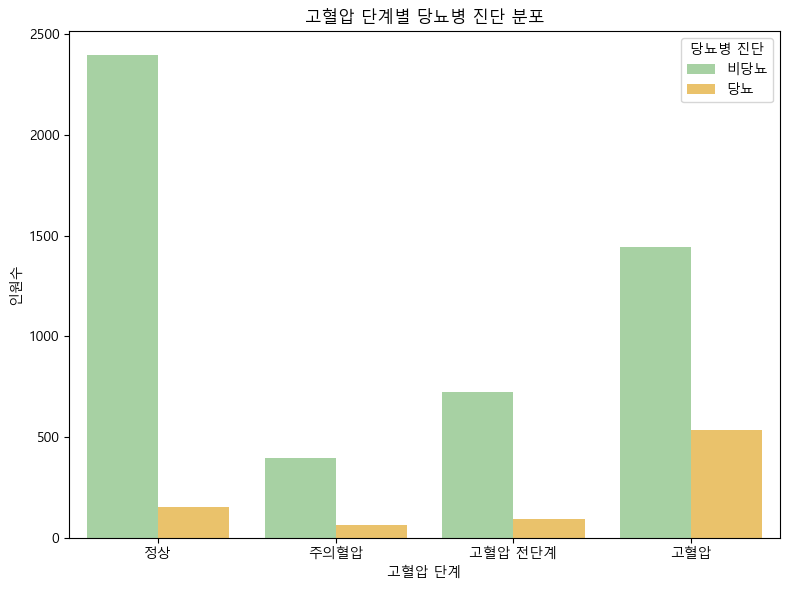

In [ ]:
# 결측치 제거 (필요 컬럼 기준)
df_analysis = df_diabetes.dropna(subset=['HE_HP'])

hp_map = {
    1.0: '정상',
    2.0: '주의혈압',
    3.0: '고혈압 전단계',
    4.0: '고혈압'
}
df_analysis['HE_HP_label'] = df_analysis['HE_HP'].map(hp_map)

# DE1_dg 이진 라벨 맵핑
df_analysis['DE1_dg_label'] = df_analysis['DE1_dg'].map({0:'비당뇨', 1:'당뇨'})

# 교차표 생성
contingency_table = pd.crosstab(df_analysis['HE_HP_label'], df_analysis['DE1_dg_label'])
print("HE_HP와 당뇨병 진단 교차표:\n", contingency_table)

# 카이제곱 검정
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"\n카이제곱 검정 결과: chi2={chi2:.3f}, p-value={p:.4f}")

# 시각화
plt.figure(figsize=(8,6))
sns.countplot(
    data=df_analysis,
    x='HE_HP_label',
    hue='DE1_dg_label',
    order=['정상', '주의혈압', '고혈압 전단계', '고혈압'],
    palette=['#A1D99B', "#FFCA56"]
)
plt.title('고혈압 단계별 당뇨병 진단 분포')
plt.xlabel('고혈압 단계')
plt.ylabel('인원수')
plt.legend(title='당뇨병 진단')
plt.tight_layout()
plt.show()

# 1차 EDA 후 csv로 저장

In [25]:
# 1차 EDA
df_diabetes.to_csv("./data/df_diabetes.csv", index=False, encoding='utf-8-sig')